In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys, time, pickle, math
%matplotlib inline

In [115]:
def import_result_penalizedEM(fname):
    with open(fname, "rb") as p:
        res1 = pickle.load(p)
    pi = [r["pi"] for r in res1]
    mu = [r["mu"] for r in res1]
    conv = [r["conv"] for r in res1]
    p_loss = [r["p_loss"] for r in res1]
    d_loss = [r["d_loss"] for r in res1]
    iters = [r["iters"] for r in res1]
    time = [r["time"] for r in res1]
    return pi, mu, conv, p_loss, d_loss, iters, time

def import_result_EM(fname):
    with open(fname, "rb") as p:
        res1 = pickle.load(p)
    pi = [r["pi"] for r in res1]
    mu = [r["mu"] for r in res1]
    conv = [r["conv"] for r in res1]
    loss = [r["loss"] for r in res1]
    time = [r["time"] for r in res1]
    return pi,mu,conv,loss,time

In [52]:
def MoG_prob(x, pi, mu):
    K, dim = mu.shape
    assert x.shape == (dim,)
    assert pi.shape == (K,)
    prob = 0.0
    for k in range(K):
        log_prob_k = -dim * 0.5 * math.log(2 * math.pi) - 0.5 * (x - mu[k]).dot(x - mu[k])
        prob += np.exp(log_prob_k) * pi[k]
    return prob

from scipy.stats import multivariate_normal as mvn

def log_likelihood(X, pi, mu, sigma):
    ll = 0.0
    for x in X:
        s = 0
        for j in range(len(pi)):
            s += pi[j] * mvn(mu[j], sigma[j]).pdf(x)
        ll += np.log(s)
    return ll

def MoG_plot(pi, mu, sig, adv_sample=None):
    plt.figure(figsize=(5, 5))
    
    x1 = x2 = np.linspace(-2.0, 8.0, 101)
    p_lists = []
    for _x1 in x1:
        p = []
        for _x2 in x2:
            p.append(log_likelihood(np.array((_x1, _x2)), pi, mu, sig) )
        p_lists.append(p)
    P = np.array(p_lists)
    
    if adv_sample is not None:
        x1 = [x[0] for x in adv_sample]
        x2 = [x[1] for x in adv_sample]
        plt.scatter(x1, x2, s=10, marker='X')

    plt.imshow(P, origin='lower', interpolation='bilinear')
    plt.xticks(np.linspace(0, 100, 6), np.linspace(-2, 8, 6))
    plt.yticks(np.linspace(0, 100, 6), np.linspace(-2, 8, 6))
    


In [22]:
with open("results_multi_adv_EM/EM-K=3-lam=1.0-N=500.p", "rb") as p:
        res1 = pickle.load(p)
pi = [r["pi"] for r in res1]
mu = [r["mu"] for r in res1]
conv = [r["conv"] for r in res1]
loss = [r["loss"] for r in res1]

In [147]:
import scipy

In [145]:
def calc_KL(P,Q, x1_linespace, x2_linespace=None):
    if x2_linespace is None:
        x2_linespace = x1_linespace
    points = [np.array((x1,x2)) for x2 in x2_linespace for x1 in x1_linespace]
    p_probs = [P(x) for x in points]
    q_probs = [Q(x) for x in points]
    KL = scipy.stats.entropy(p_probs, q_probs)
    return KL

In [144]:
def kl_to_original(pi,mu,sigma):
    P = lambda x: log_likelihood(x, pi, mu,sigma)
    true_pi =  np.array([0.2]*5)
    true_mu = np.array([(0.5, 0.5), (0.5, 2.5), (1.5, 1.5), (2.5, 0.5), (2.5, 2.5)]) * 2
    Q = lambda x: log_likelihood(x, true_pi, true_mu, [np.eye(2)]*5)
    return calc_KL(P,Q, np.linspace(-2, 8, 101))

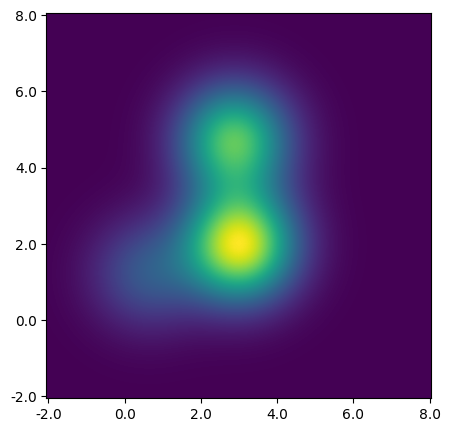

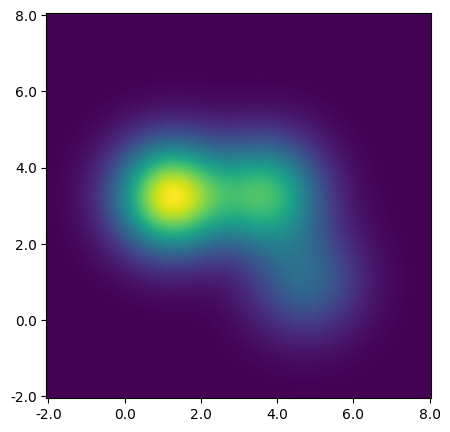

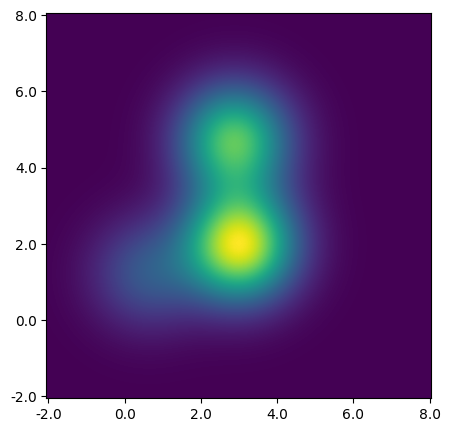

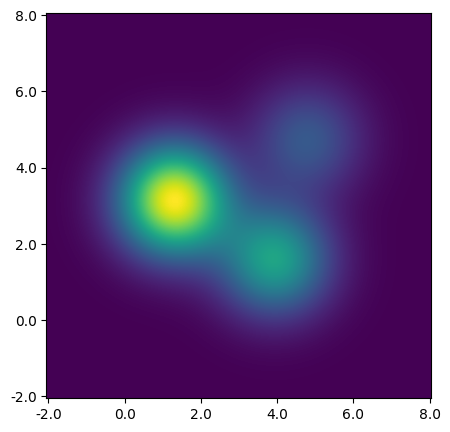

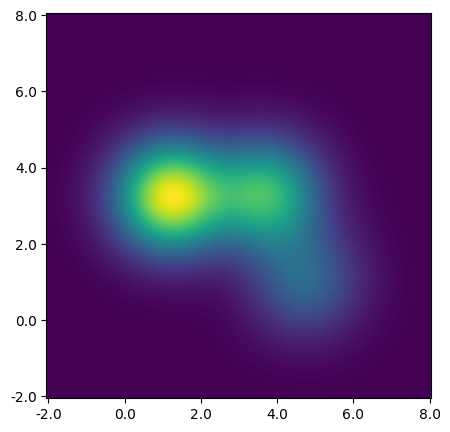

In [23]:
plt.style.use('default')
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i])

In [121]:
#K=5-lam=1.0-N=1000
pi, mu, _, p_loss, d_loss, iters, time1 = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=5-lam=0.1-N=1000.p")

plt.style.use('seaborn-whitegrid')

In [139]:
pi,mu,conv,loss,time1 = import_result_EM("results_multi_adv_EM/EM-K=10-lam=1.0-N=100.p")
np.average(time1)

29.46217934290568

In [78]:
_, _, _, _, _, iters2, time2 = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=5-lam=0.1-N=1000.p")
_, _, _, _, _, iters3, time3 = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=5-lam=10.0-N=1000.p")


In [122]:
np.average(time1)

459.78831418355304

Losses

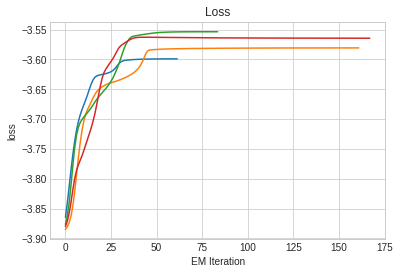

In [4]:
fig = plt.figure()
ax = plt.axes()

plt.title("Loss")
plt.xlabel("EM Iteration")
plt.ylabel("loss");
x = np.linspace(0, 180, 180)
for loss in d_loss:
    ax.plot(x[:len(loss)-1], loss[1:])


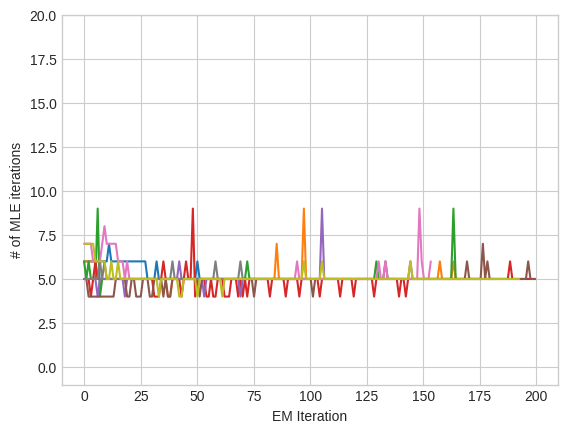

In [76]:
fig = plt.figure()
ax = plt.axes()

plt.ylim(-1, 20);
#plt.title("Inner Loop iterations")
plt.xlabel("EM Iteration")
plt.ylabel("# of MLE iterations");
x = np.linspace(0, 500, 500)
for i in iters+iters2+iters3:
    ax.plot(x[:len(i)], i)


In [21]:
data_fname = 'data_multi_adv.npz'
load_data = np.load(data_fname)
true_pi = load_data['pi']
true_mu = load_data['mu']
samples = load_data['samples']
adv_sample = load_data['adv_sample']

In [8]:
true_pi

array([0.0960792 , 0.17889669, 0.25452535, 0.19189888, 0.27859988])

In [9]:
true_mu

array([[1., 1.],
       [1., 5.],
       [3., 3.],
       [5., 1.],
       [5., 5.]])

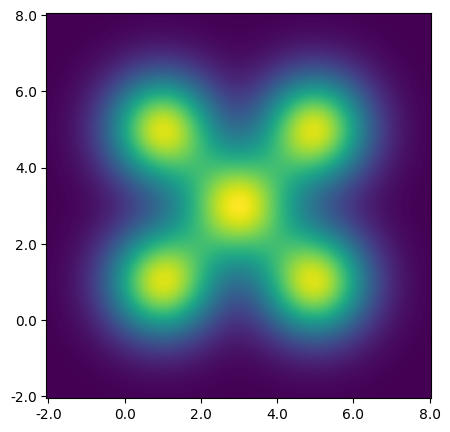

In [23]:
plt.style.use('default')
MoG_plot(np.array([0.2]*5), true_mu)

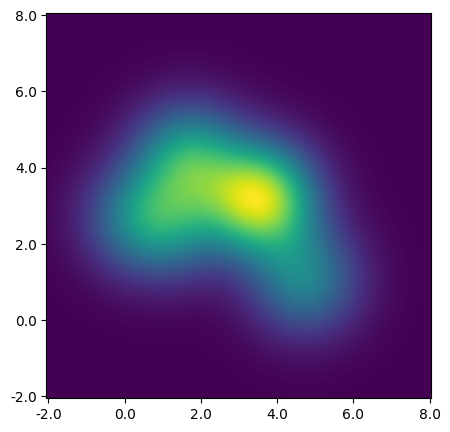

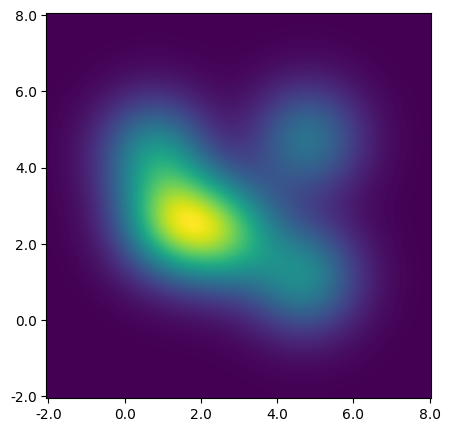

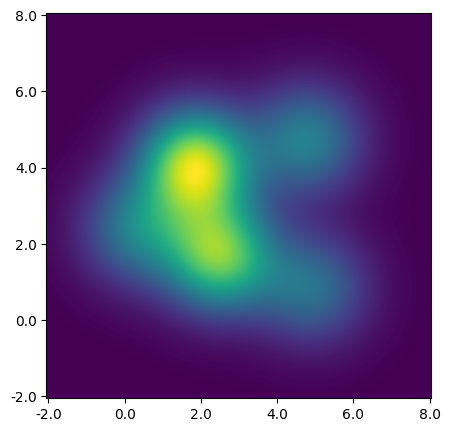

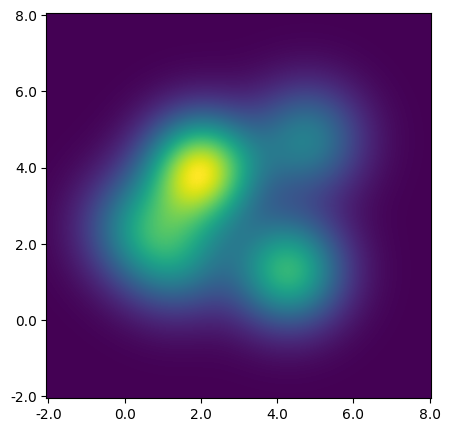

In [11]:
plt.style.use('default')
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i])

In [15]:
#K=5-lam=0.1
pi, mu, _, p_loss, d_loss, iters, _ = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=5-lam=0.1-N=500.p")
plt.style.use('seaborn-whitegrid')

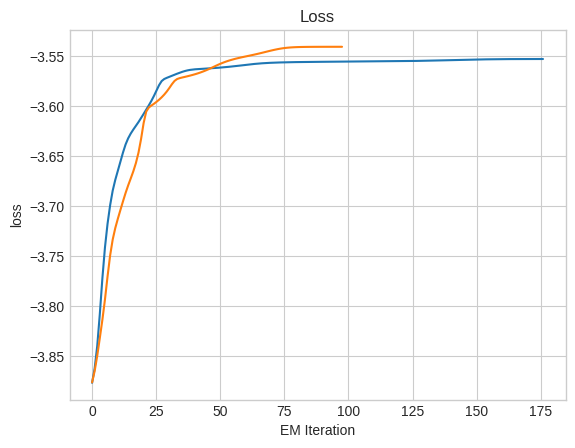

In [17]:
fig = plt.figure()
ax = plt.axes()

plt.title("Loss")
plt.xlabel("EM Iteration")
plt.ylabel("loss");
x = np.linspace(0, 200, 200)
for loss in d_loss:
    ax.plot(x[:len(loss)-1], loss[1:])

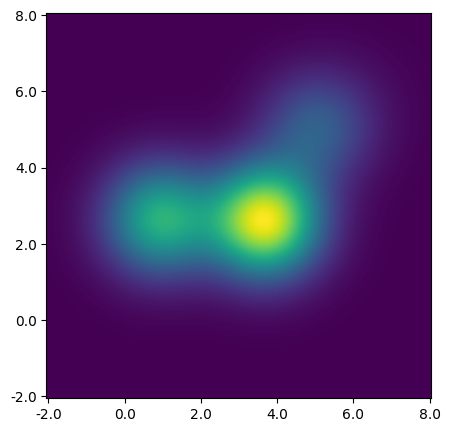

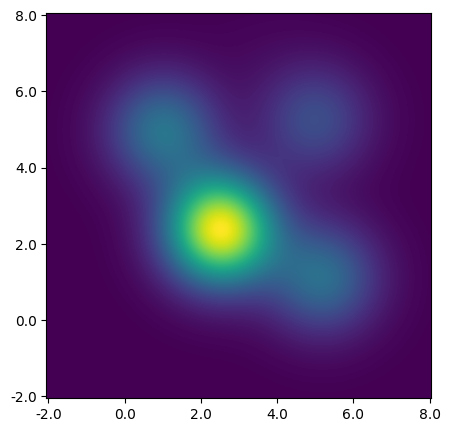

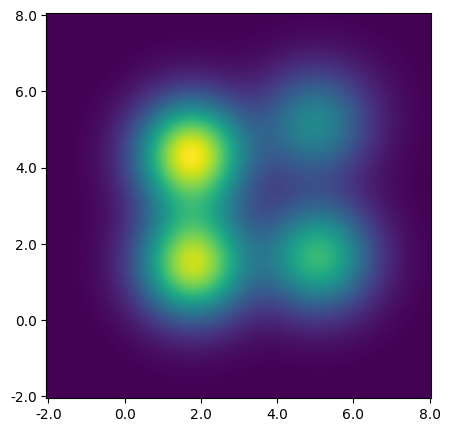

In [24]:
plt.style.use('default')
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i])

In [27]:
#K=5-lam=0.1
pi, mu, _, p_loss, d_loss, iters, _ = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=5-lam=1.0-N=1000.p")
plt.style.use('seaborn-whitegrid')

In [31]:
mu

[array([[3.92089163, 2.08664193],
        [4.8455257 , 4.95808326],
        [1.29888835, 5.04314324],
        [6.27921316, 5.46424368],
        [1.1470495 , 1.07079003]]), array([[1.17911155, 5.15252823],
        [5.00699989, 1.01336048],
        [5.06829041, 4.96265327],
        [2.34767233, 2.36596304],
        [5.86482227, 6.27235922]]), array([[4.420187  , 1.56312681],
        [1.19191146, 1.0471642 ],
        [4.92979421, 4.95817388],
        [1.83130771, 4.49063152],
        [6.22122314, 5.59134174]])]

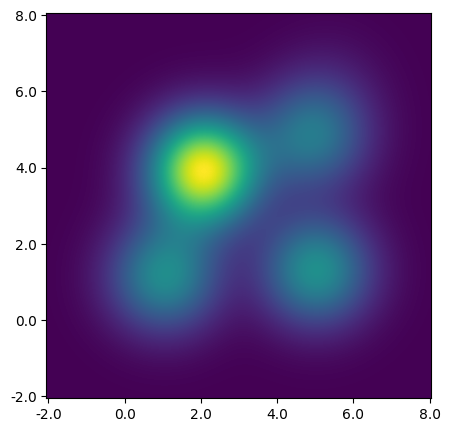

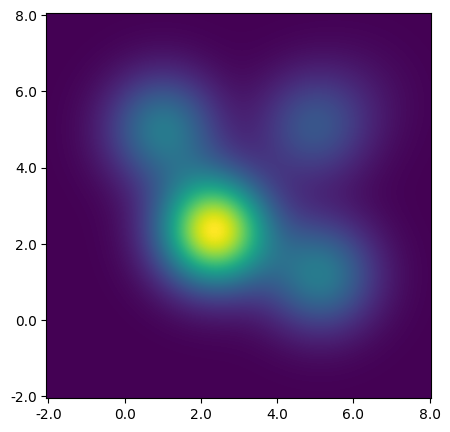

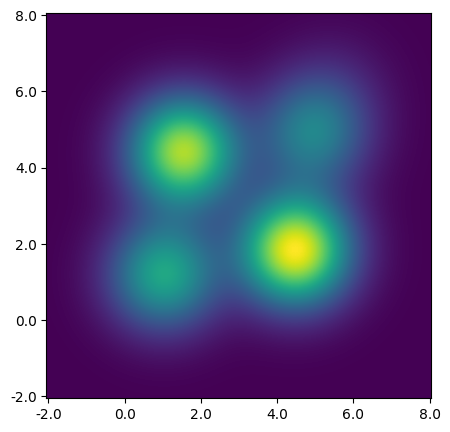

In [29]:
plt.style.use('default')

for i in range(len(pi)):
    MoG_plot(pi[i], mu[i])

In [19]:
pi

[array([0.32671658, 0.5123676 , 0.00352739, 0.00269701, 0.15469142]),
 array([0.50212219, 0.11854384, 0.18059456, 0.19196557, 0.00677385]),
 array([0.3245517 , 0.22073718, 0.29949146, 0.00341487, 0.15180479])]

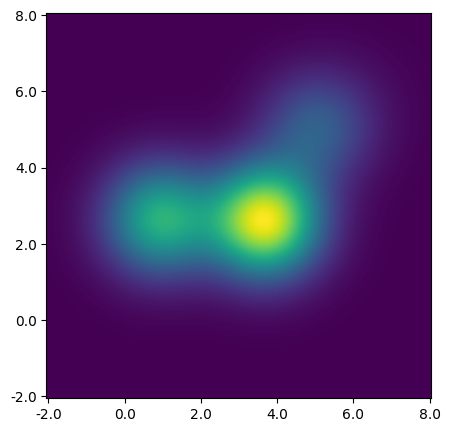

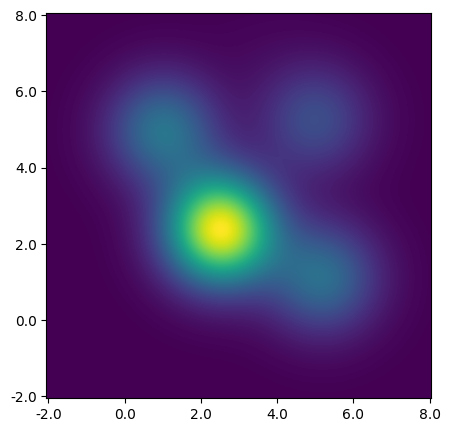

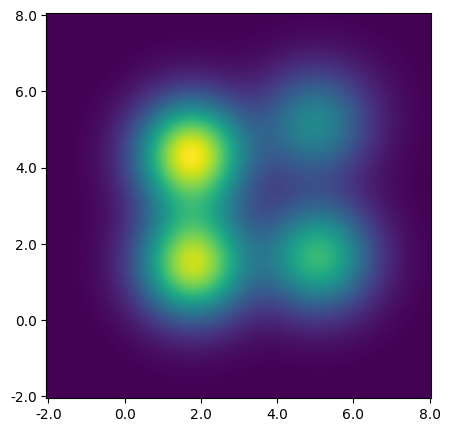

In [20]:
plt.style.use('default')
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i])

In [16]:
pi, mu, _, p_loss, d_loss, iters, _ = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=5-lam=1.0-N=1000.p")
plt.style.use('default')

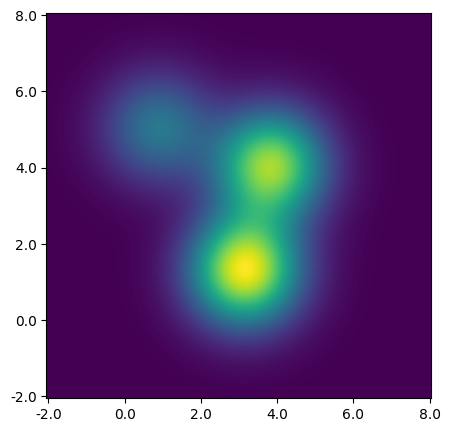

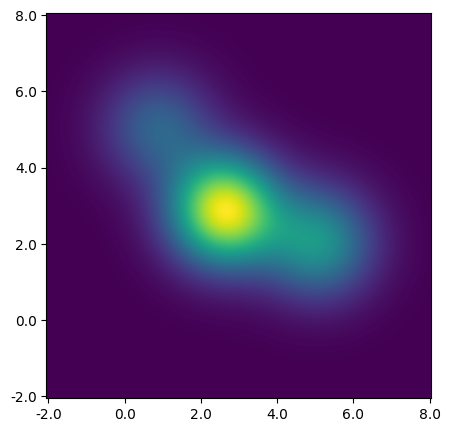

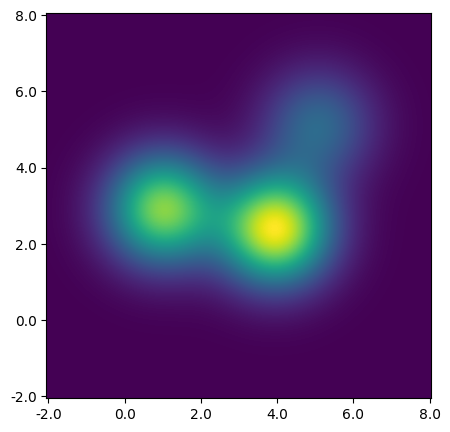

In [17]:
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i])

In [160]:
with open("results_multi_adv_EM/EM-K=5-lam=1.0-N=100.p", "rb") as p:
        res1 = pickle.load(p)
pi = [r["pi"] for r in res1]
mu = [r["mu"] for r in res1]
conv = [r["conv"] for r in res1]
loss = [r["loss"] for r in res1]

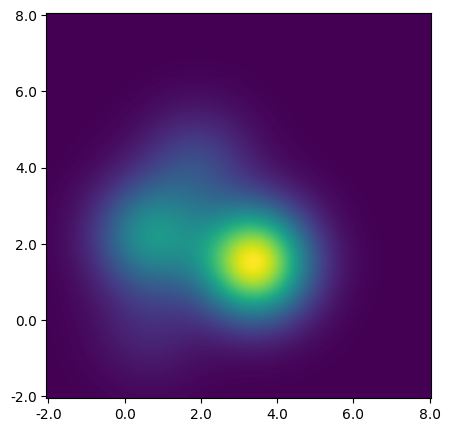

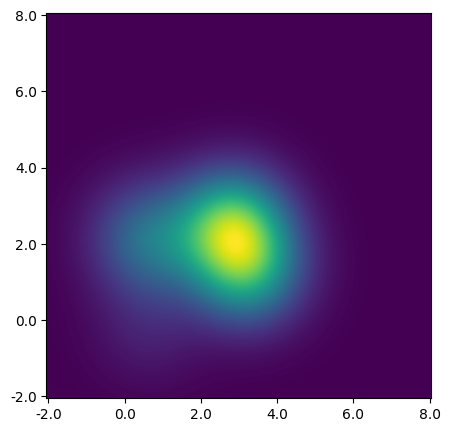

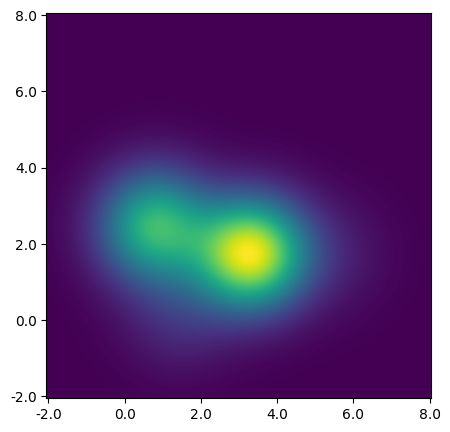

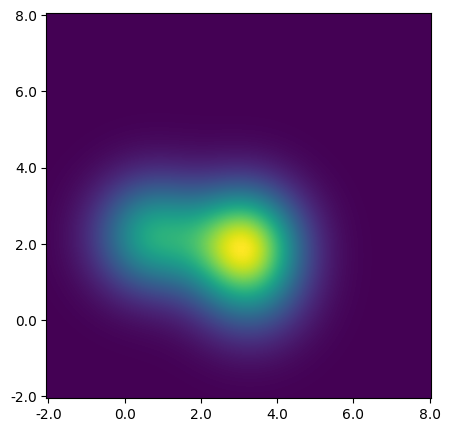

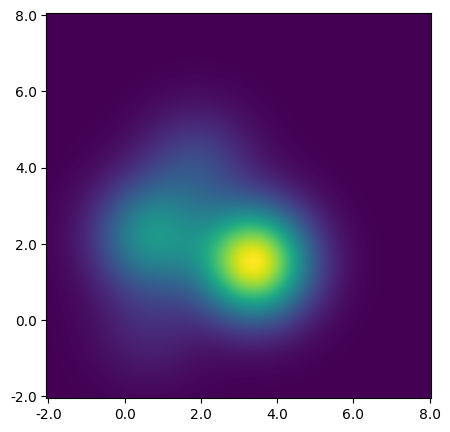

In [159]:
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i])

In [149]:
with open("results_multi_adv_EM/EM-K=5-lam=10.0-N=1000.p", "rb") as p:
        res1 = pickle.load(p)
pi = [r["pi"] for r in res1]
mu = [r["mu"] for r in res1]
conv = [r["conv"] for r in res1]
loss = [r["loss"] for r in res1]

In [54]:
adv_sample

array([[1., 3.],
       [3., 1.],
       [3., 5.],
       [5., 3.]])

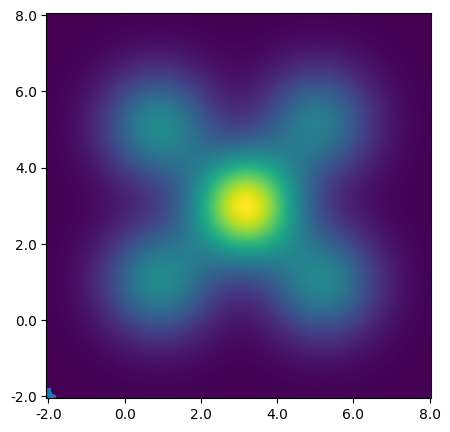

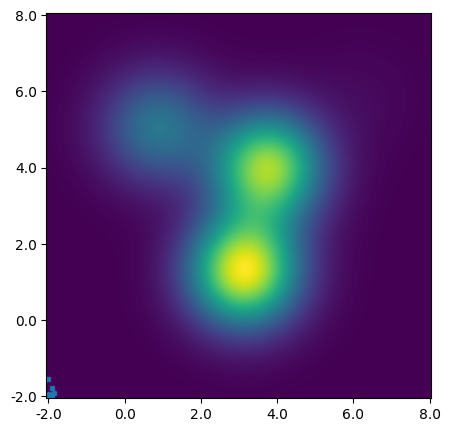

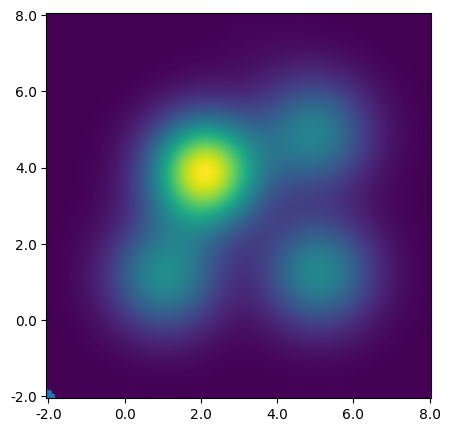

In [58]:
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i], conv[i])#, adv_sample=adv_sample)

In [62]:
pi

[array([0.14327404, 0.16390214, 0.17309359, 0.16385876, 0.35587147]),
 array([0.01654985, 0.15846931, 0.01044718, 0.43904763, 0.37548604]),
 array([0.1966196 , 0.00667763, 0.20027757, 0.41314232, 0.18328288])]

EM

In [150]:
kl_to_original(pi[0],mu[0],conv[0])

0.0037789537170982487

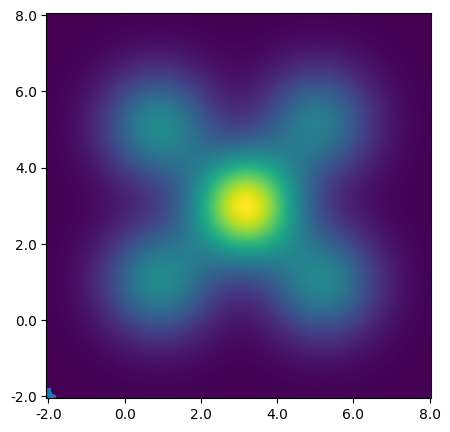

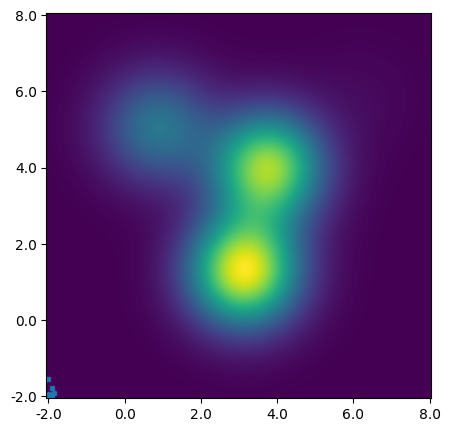

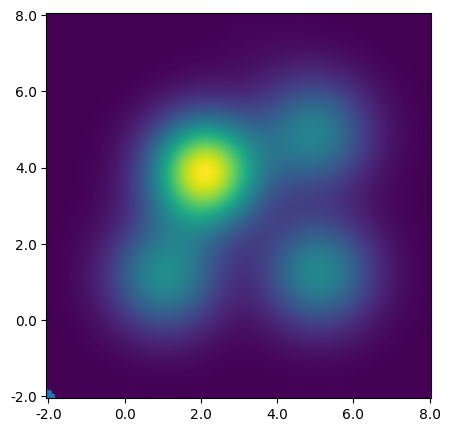

In [152]:
plt.style.use('default')
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i], conv[i])#, adv_sample=adv_sample)

penalized

In [155]:
pi, mu, conv, p_loss, d_loss, iters, _ = import_result_penalizedEM("results_multi_adv_EM/Penalized-K=5-lam=10.0-N=1000.p")

In [157]:
kl_to_original(pi[0],mu[0],conv[0])

0.004059763614829317

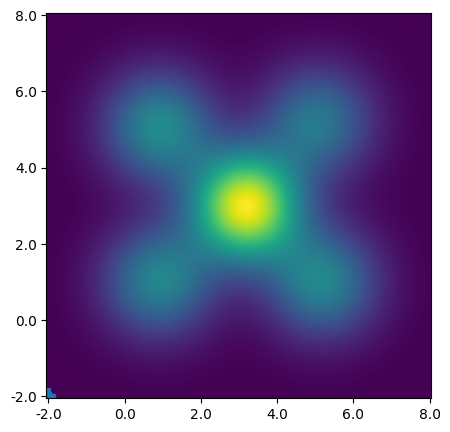

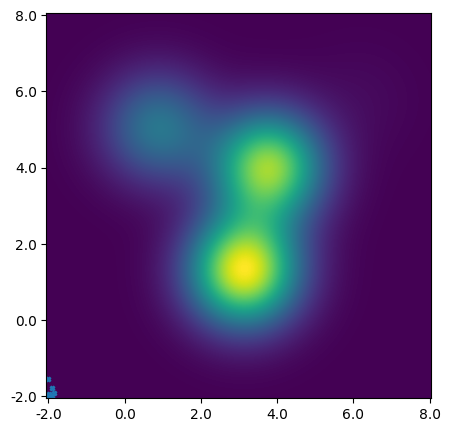

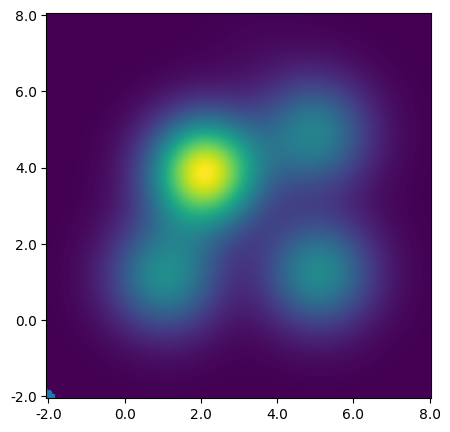

In [156]:
for i in range(len(pi)):
    MoG_plot(pi[i], mu[i], conv[i])#, adv_sample=adv_sample)